- 다중 분류 문제
    - 정답 데이터
        - 1차원 형태의 텐서, int64
    - 예측값을 확률로 변경할 때
        - softmax
    - 예측 확률을 class 번호로 결정해줘야 할 때
        - np.argmax
    - 손실함수
        - CrossEntropy

# 고기 분류 데이터셋
- 학습용 csv 파일: train/class_info.csv
- 테스트용 csv 파일: test/class_info.csv
- 0: 신선한 고기
- 1: 먹을만한 고기
- 2: 상한 고기

In [31]:
# !gdown 1Jy5vgN8LvHTMpXkJeR0hO_b74VAvt8K_
# !unzip -oqq meat.zip

In [32]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [33]:
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
train = pd.read_csv("train/class_info.csv")
test = pd.read_csv("test/class_info.csv")

train.shape, test.shape

((1246, 2), (1020, 2))

In [35]:
train.head()

,filename,target
0,1074.jpg,0
1,1222.jpg,1
2,2105.jpg,1
3,81.jpg,2
4,1791.jpg,2


In [36]:
train_path = ("train/" + train["filename"]).to_numpy()
test_path = ("test/" + test["filename"]).to_numpy()

array([[[217, 205, 193],
        [211, 199, 187],
        [207, 195, 183],
        ...,
        [163, 144, 137],
        [158, 137, 132],
        [159, 138, 133]],

       [[215, 203, 191],
        [210, 198, 186],
        [207, 195, 183],
        ...,
        [177, 158, 151],
        [164, 143, 138],
        [158, 137, 132]],

       [[211, 199, 187],
        [208, 196, 184],
        [207, 195, 183],
        ...,
        [197, 178, 171],
        [179, 158, 153],
        [166, 145, 140]],

       ...,

       [[149, 131, 117],
        [153, 135, 121],
        [157, 139, 125],
        ...,
        [128,  72,  71],
        [143,  87,  86],
        [134,  78,  77]],

       [[148, 130, 116],
        [152, 134, 120],
        [156, 138, 124],
        ...,
        [118,  62,  61],
        [135,  79,  78],
        [135,  79,  78]],

       [[147, 129, 115],
        [151, 133, 119],
        [155, 137, 123],
        ...,
        [116,  60,  59],
        [136,  80,  79],
        [146,  90,  89]]], dtype=uint8)
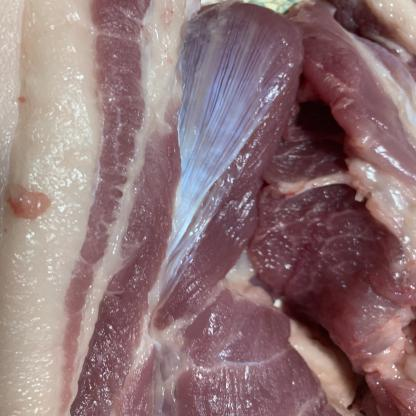

In [37]:
import cv2
arr = cv2.imread(train_path[0])
arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
arr

- 정답 데이터

In [38]:
target = train["target"].to_numpy()
target.shape, target.dtype

((1246,), dtype('int64'))

# transform 객체

In [39]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [40]:
resize = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_list = [
    # 증강
    A.Resize(*resize),
    A.Normalize(mean, std),
    ToTensorV2()
]

train_transform = A.Compose(train_list)

test_list = [
    A.Resize(*resize),
    A.Normalize(mean, std),
    ToTensorV2()
]

test_transform = A.Compose(test_list)

# 데이터셋 객체

In [41]:
class MeatDataset(torch.utils.data.Dataset):
    def __init__(self, transform, x, y=None):
        self.transform, self.x, self.y = transform, x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item = {}
        x = cv2.imread(self.x[idx])
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        item["x"] = self.transform(image=x)["image"]
        if self.y is not None:
            item["y"] = torch.tensor(self.y[idx])

        return item

In [42]:
dataset = MeatDataset(train_transform, train_path, target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2)
batch = next(iter(dataloader))
batch

{'x': tensor([[[[ 1.5468,  1.4269,  1.5639,  ...,  1.4269,  0.8618,  0.6049],
           [ 1.4612,  1.4440,  1.4954,  ...,  1.5982,  1.3755,  0.9132],
           [ 1.4269,  1.4783,  1.4269,  ...,  1.6838,  1.5810,  1.3927],
           ...,
           [ 0.4166,  0.5193,  0.5536,  ...,  0.2282,  0.1768,  0.3994],
           [ 0.4508,  0.5707,  0.5878,  ..., -0.0801,  0.1083,  0.2453],
           [ 0.4337,  0.5536,  0.5707,  ...,  0.0398, -0.1143,  0.2624]],
 
          [[ 1.5007,  1.3782,  1.5182,  ...,  1.3431,  0.6779,  0.3803],
           [ 1.4132,  1.3957,  1.4482,  ...,  1.5357,  1.2206,  0.6954],
           [ 1.3782,  1.4307,  1.3782,  ...,  1.6232,  1.4482,  1.2206],
           ...,
           [ 0.2402,  0.3452,  0.3803,  ..., -0.5826, -0.6352, -0.4076],
           [ 0.2927,  0.3978,  0.4153,  ..., -0.8978, -0.7402, -0.6001],
           [ 0.2577,  0.3803,  0.3978,  ..., -0.8102, -0.9678, -0.5826]],
 
          [[ 1.5071,  1.3851,  1.5245,  ...,  1.4025,  0.7751,  0.5136],
        

# timm 라이브러리
- 이미지 분야의 다양한 사전학습 모델 제공
- pytorch 기반의 다양한 이미지 관련 모델의 아키텍쳐를 쉽게 사용할 수 있음
- 설치
```bash
pip install timm
```

In [43]:
import timm

- 사전학습 모델 확인하기

In [44]:
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [45]:
timm.list_models('*efficient*', pretrained=True)

['efficientformer_l1.snap_dist_in1k',
 'efficientformer_l3.snap_dist_in1k',
 'efficientformer_l7.snap_dist_in1k',
 'efficientformerv2_l.snap_dist_in1k',
 'efficientformerv2_s0.snap_dist_in1k',
 'efficientformerv2_s1.snap_dist_in1k',
 'efficientformerv2_s2.snap_dist_in1k',
 'efficientnet_b0.ra4_e3600_r224_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1.ra4_e3600_r240_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'ef

In [46]:
model_name = 'efficientnet_b0.ra4_e3600_r224_in1k'
model_name

'efficientnet_b0.ra4_e3600_r224_in1k'

## create_model 함수
- 사전학습된 모델을 pytorch 모델 객체로 반환
- 첫 번째 인수로 모델 ID명 전달

In [47]:
model = timm.create_model(model_name, pretrained=True, num_classes=3).to(device)

In [48]:
model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/efficientnet_b0.ra4_e3600_r224_in1k',
 'architecture': 'efficientnet_b0',
 'tag': 'ra4_e3600_r224_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 256, 256),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [49]:
class Net(torch.nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.pre_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.pre_model(x)

In [50]:
model = Net(model_name, 3)
model(batch["x"])

tensor([[ 0.2654, -1.7277, -1.2139],
        [-1.9481,  0.7435, -2.8849]], grad_fn=<AddmmBackward0>)

# 학습 루프

In [51]:
def train_loop(dataloader, model, loss_function, optimizer, device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_function(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    return epoch_loss

# 테스트 루프

In [52]:
@torch.no_grad()
def test_loop(dataloader, model, loss_function, device):
    epoch_loss = 0
    model.eval()

    act = torch.nn.Softmax(dim=1)
    pred_list = []
    for batch in dataloader:
        pred = model( batch["x"].to(device) )
        if batch.get("y") is not None:
            loss = loss_function(pred, batch["y"].to(device) )
            epoch_loss += loss.item()

        pred = act(pred)
        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    pred = np.concatenate(pred_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred

# 하이퍼파라미터

In [53]:
n_splits = 5
batch_size = 32
epochs = 100
loss_function = torch.nn.CrossEntropyLoss()

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

cv = KFold(n_splits, shuffle=True, random_state=SEED)

# 학습

In [55]:
is_holdout = False
reset_seeds(SEED)
score_list = []
for i, (tri, vai) in enumerate(cv.split(train_path)):
    # 학습 데이터
    x_train, y_train = train_path[tri], target[tri]
    train_dataset = MeatDataset(train_transform, x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 검증 데이터
    x_valid, y_valid = train_path[vai], target[vai]
    valid_dataset = MeatDataset(test_transform, x_valid, y_valid)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # 모델 객체 및 옵티마이저 생성
    model = Net(model_name, 3).to(device)
    optimizer = torch.optim.Adam( model.parameters() )

    patience = 0 # 조기 종료 조건을 주기 위한 변수
    best_score = 0 # 현재 최고점수
    for _ in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss_function, optimizer, device)
        valid_loss, pred = test_loop(valid_dataloader, model, loss_function, device)
        pred = np.argmax(pred, axis=1)
        score = accuracy_score(y_valid, pred)

        print(f"train_loss: {train_loss: .4f}, valid_loss: {valid_loss: .4f}, score: {score: .4f}")
        patience += 1

        if score > best_score:
            best_score = score
            patience = 0
            torch.save( model.state_dict(), f"model{i}.pt" )

        if patience == 5:
            break

    score_list.append(best_score)
    print(f"ACC 최고점수: {best_score}")

    if is_holdout:
        break

train_loss:  1.8423, valid_loss:  34.9995, score:  0.3760
train_loss:  0.6004, valid_loss:  1.0956, score:  0.7520
train_loss:  1.0332, valid_loss:  7.6603, score:  0.6520
train_loss:  0.5011, valid_loss:  38.1594, score:  0.5680
train_loss:  0.4144, valid_loss:  0.2097, score:  0.9240
train_loss:  0.2576, valid_loss:  0.0643, score:  0.9720
train_loss:  0.1283, valid_loss:  0.0460, score:  0.9840
train_loss:  0.0596, valid_loss:  0.0720, score:  0.9800
train_loss:  0.2734, valid_loss:  0.1875, score:  0.9320
train_loss:  0.3553, valid_loss:  0.2950, score:  0.8840
train_loss:  0.1024, valid_loss:  0.0480, score:  0.9880
train_loss:  0.0563, valid_loss:  0.0810, score:  0.9760
train_loss:  0.0201, valid_loss:  0.0264, score:  0.9880
train_loss:  0.1450, valid_loss:  0.0550, score:  0.9800
train_loss:  0.1471, valid_loss:  0.0706, score:  0.9800
train_loss:  0.0348, valid_loss:  0.0468, score:  0.9920
train_loss:  0.0495, valid_loss:  0.0428, score:  0.9800
train_loss:  0.0693, valid_lo

# 테스트 데이터 예측

In [56]:
test_dataset = MeatDataset(test_transform, test_path)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
pred_list = []

for i in range(n_splits):
    model = Net(model_name, 3).to(device)
    state_dict = torch.load(f"model{i}.pt", weights_only=True)
    model.load_state_dict(state_dict)
    _, pred = test_loop(test_dataloader, model, None, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)
pred = np.argmax(pred, axis=1)
pred

array([2, 1, 1, ..., 2, 1, 0])

In [58]:
pd.DataFrame(pred, columns=["target"]).to_csv("권지혁.csv", index=False)